In [12]:
# Assignment 6: Model comparisions (10 pts)

In [13]:
import numpy as np

import matplotlib.pyplot as plt

In [14]:
# Download the dataset used in this assignment
!gdown 1rYUDnQwYmnRnf1Tbn_OeNFVydtJdUpZ-

Downloading...
From: https://drive.google.com/uc?id=1rYUDnQwYmnRnf1Tbn_OeNFVydtJdUpZ-
To: /content/data_RSA.npy
100% 140k/140k [00:00<00:00, 5.08MB/s]


### Dataset description
In this assignment, the dataset you will be using is the same dataset as used in Assignment 5.

In [15]:
# Read in data
data_RSA = np.load('data_RSA.npy',allow_pickle=True).item() # A data dictonary containing all the data needed
print(data_RSA.keys())
print(data_RSA['fMRI'].shape) # number of trials and voxels

dict_keys(['model1', 'model2', 'model3', 'fMRI'])
(60, 100)


#### ✏️ Do it yourself (1 pts):
Conduct the RSA analysis with each of the three computational models. Report the `Pearson` correlation of the fMRI RDM with all three model RDMs as the brain scores.
_Hint: you need to compute Pearson correlation, rather than Spearman correlation this time_

In [16]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

# Helper: upper triangle indices (excluding diagonal)
def upper_tri(matrix):
    """Return the upper-triangle values of a square matrix (no diagonal)."""
    idx = np.triu_indices_from(matrix, k=1)
    return matrix[idx]

# 1. Build the fMRI RDM
fmri_data = data_RSA['fMRI']           # shape: (n_trials, n_voxels)
n_trials = fmri_data.shape[0]

# Pairwise Euclidean distance → RDM
fmri_rdm = squareform(pdist(fmri_data, metric='euclidean'))

# Build the three model RDMs
model_names  = ['model1', 'model2', 'model3']   # adjust keys to match data_RSA
model_rdms   = {}

for name in model_names:
    model_data      = data_RSA[name]             # shape: (n_trials, n_features)
    model_rdms[name] = squareform(pdist(model_data, metric='euclidean'))

# Brain scores – Pearson correlation of RDM vectors
fmri_vec = upper_tri(fmri_rdm)          # flatten upper triangle

brain_scores = {}
for name in model_names:
    model_vec          = upper_tri(model_rdms[name])
    r, _               = pearsonr(fmri_vec, model_vec)
    brain_scores[name] = r
    print(f"{name}  →  Pearson r = {r:.4f}")


model1  →  Pearson r = 0.5148
model2  →  Pearson r = 0.9608
model3  →  Pearson r = 0.5752


#### ✏️ Do it yourself (3 pts):
Estimate the 95% confidence interval for each of the three models’ brain scores separately using bootstrap resampling (1000 iterations).

model1  →  95% CI = [0.5333,  0.6294]
model2  →  95% CI = [0.9484,  0.9653]
model3  →  95% CI = [0.5222,  0.7495]


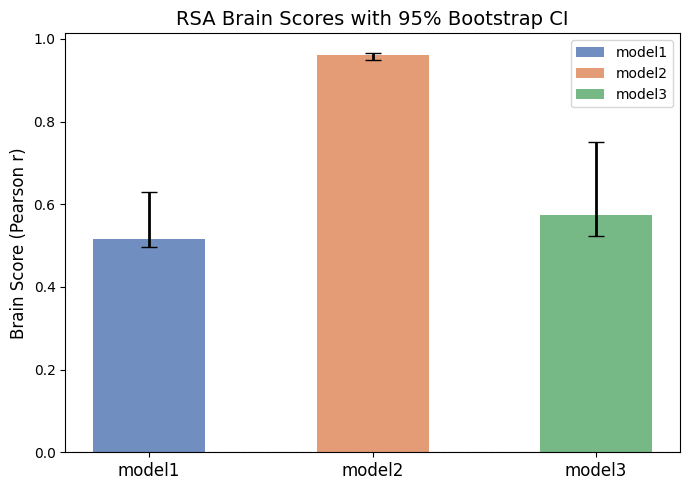

In [17]:

# Bootstrap 95 % confidence intervals (1 000 iterations)
n_boot      = 1000
rng         = np.random.default_rng(42)
ci          = {}

for name in model_names:
    boot_r = np.zeros(n_boot)

    for i in range(n_boot):
        # Resample TRIALS (rows/columns of the RDM simultaneously)
        idx          = rng.choice(n_trials, size=n_trials, replace=True)

        # Sub-sample both RDMs with the same trial indices
        fmri_boot    = upper_tri(fmri_rdm[np.ix_(idx, idx)])
        model_boot   = upper_tri(model_rdms[name][np.ix_(idx, idx)])

        r_boot, _    = pearsonr(fmri_boot, model_boot)
        boot_r[i]    = r_boot

    ci[name] = (np.percentile(boot_r, 2.5), np.percentile(boot_r, 97.5))
    print(f"{name}  →  95% CI = [{ci[name][0]:.4f},  {ci[name][1]:.4f}]")

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

x_pos = np.arange(len(model_names))
colors = ['#4C72B0', '#DD8452', '#55A868']

for i, name in enumerate(model_names):
    r      = brain_scores[name]
    lo, hi = ci[name]
    ax.bar(i, r, color=colors[i], alpha=0.8, width=0.5, label=name)
    # Use absolute yerr values — distance from the observed r to each CI bound
    err_lo = abs(r - lo)
    err_hi = abs(hi - r)
    ax.errorbar(i, r,
                yerr=[[err_lo], [err_hi]],
                fmt='none', color='black', capsize=6, linewidth=2)

ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.set_ylabel('Brain Score (Pearson r)', fontsize=12)
ax.set_title('RSA Brain Scores with 95% Bootstrap CI', fontsize=14)
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.legend()
plt.tight_layout()
plt.show()

#### ✏️ Do it yourself (1 pt):
Plot each model's brain score with its 95% confidence interval _in the same figure_.
The x-axis should be the three models, ordered from the lowest performance to best performance.
The y-axis is brain score.

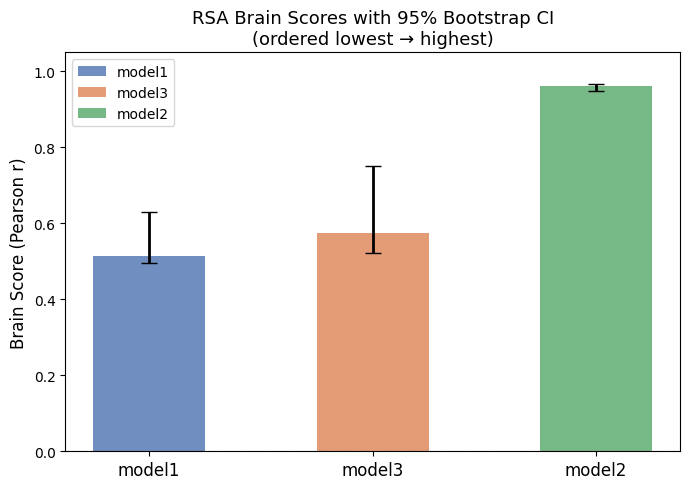

In [18]:
# Order models from lowest to highest brain score
ordered_models = sorted(model_names, key=lambda name: brain_scores[name])

fig, ax = plt.subplots(figsize=(7, 5))

colors = ['#4C72B0', '#DD8452', '#55A868']

for i, name in enumerate(ordered_models):
    r      = brain_scores[name]
    lo, hi = ci[name]
    ax.bar(i, r, color=colors[i], alpha=0.8, width=0.5, label=name)
    err_lo = abs(r - lo)
    err_hi = abs(hi - r)
    ax.errorbar(i, r,
                yerr=[[err_lo], [err_hi]],
                fmt='none', color='black', capsize=6, linewidth=2)

ax.set_xticks(np.arange(len(ordered_models)))
ax.set_xticklabels(ordered_models, fontsize=12)
ax.set_ylabel('Brain Score (Pearson r)', fontsize=12)
ax.set_title('RSA Brain Scores with 95% Bootstrap CI\n(ordered lowest → highest)', fontsize=13)
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()

#### ✏️ Do it yourself (2 pts):
Based on the plot above, you now want to determine whether the lowest-performing model is _significantly worse_ than the best-performing model.

What statistical analysis should you perform, and why? (1 pt)

Should this be a one-tailed or two-tailed test? Explain your reasoning (1 pt).

Write your answer here:
> **Answer:**
> You should perform a permutation test to know the difference between the worst-performing and the best-performing models. Specifically, on each bootstrap iteration we resample trials, compute both models' brain scores, and record the difference. This gives you a null/sampling distribution of the difference under resampling, from which we can derive a p-value.

> This should be a one-tailed test. The question being asked is directional: is the lowest-performing model significantly worse than the best? You have a clear, pre-specified direction of the hypothesis (model1 < model2). A two-tailed test would also consider the possibility that model1 outperforms model2.
>   

#### ✏️ Do it yourself (3 pts):
Test your hypothesis that the lowest performing model is indeed singificantly worse than the best performing model (1000 iterations) and get the p-value (2 pts).

Compare the p-value to the critical threshold (alpha = 0.05) to determine if your hypothesis is supported or not (1 pt).

_Hint: apply the same permutation to both models in each iteration_

Observed difference (model1 - model2): -0.4460
p-value (one-tailed): 0.0020

p = 0.0020 < α = 0.05 → Reject H0.
model1 is significantly WORSE than model2.


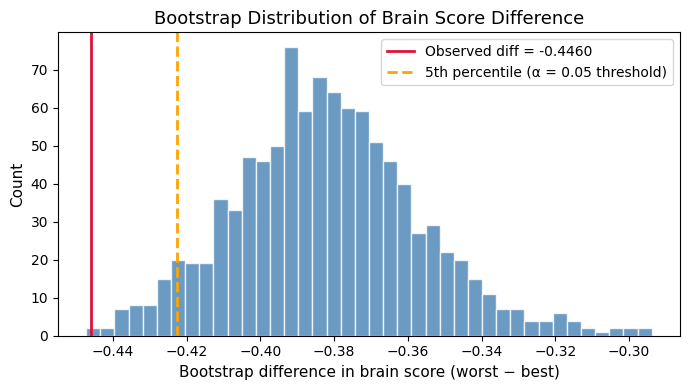

In [19]:

worst_model = ordered_models[0]   # model1 (lowest)
best_model  = ordered_models[-1]  # model2 (highest)

# Observed difference (should be negative: worst - best)
observed_diff = brain_scores[worst_model] - brain_scores[best_model]
print(f"Observed difference ({worst_model} - {best_model}): {observed_diff:.4f}")

n_boot = 1000
rng    = np.random.default_rng(42)
boot_diffs = np.zeros(n_boot)

for i in range(n_boot):
    # Same resampled trial indices applied to BOTH models
    idx = rng.choice(n_trials, size=n_trials, replace=True)

    fmri_boot  = upper_tri(fmri_rdm[np.ix_(idx, idx)])
    worst_boot = upper_tri(model_rdms[worst_model][np.ix_(idx, idx)])
    best_boot  = upper_tri(model_rdms[best_model][np.ix_(idx, idx)])

    r_worst, _ = pearsonr(fmri_boot, worst_boot)
    r_best,  _ = pearsonr(fmri_boot, best_boot)

    boot_diffs[i] = r_worst - r_best

# One-tailed p-value: proportion of bootstrap differences <= observed difference
p_value = np.mean(boot_diffs <= observed_diff)
print(f"p-value (one-tailed): {p_value:.4f}")

# Decision
alpha = 0.05
if p_value < alpha:
    print(f"\np = {p_value:.4f} < α = {alpha} → Reject H0.")
    print(f"{worst_model} is significantly WORSE than {best_model}.")
else:
    print(f"\np = {p_value:.4f} >= α = {alpha} → Fail to reject H0.")

# Plot bootstrap distribution of differences
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(boot_diffs, bins=40, color='steelblue', alpha=0.8, edgecolor='white')
ax.axvline(observed_diff, color='crimson', linewidth=2,
           label=f'Observed diff = {observed_diff:.4f}')
ax.axvline(np.percentile(boot_diffs, 5), color='orange', linewidth=2,
           linestyle='--', label='5th percentile (α = 0.05 threshold)')
ax.set_xlabel('Bootstrap difference in brain score (worst − best)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Bootstrap Distribution of Brain Score Difference', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()